Match found at (383, 48), (805, 134) with confidence 1.00
Match found at (1053, 74), (1332, 140) with confidence 1.00
Match found at (56, 524), (379, 598) with confidence 1.00
Offset top: (670, 26)
Offset bottom: (-327, 476)


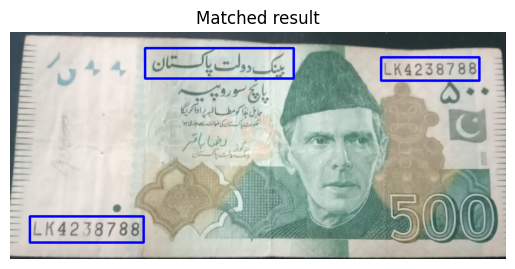

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the main image and the template image
img = cv2.cvtColor(cv2.imread('currency note data set/image17.jpg'), cv2.COLOR_BGR2RGB)
template = cv2.cvtColor(cv2.imread('currency note data set/template.jpg'), cv2.COLOR_BGR2RGB)
serial_num_img_top = cv2.cvtColor(cv2.imread('currency note data set/topSrNumber.jpg'), cv2.COLOR_BGR2RGB)
serial_num_img_bottom = cv2.cvtColor(cv2.imread('currency note data set/bottomSrNumber.jpg'), cv2.COLOR_BGR2RGB)

templates = []
templates.append(template)
templates.append(serial_num_img_top)
templates.append(serial_num_img_bottom)
top_lefts = []

def matchTemplates(img, templates):
    # Perform template matching
    for i, template in enumerate(templates):
        # Get template dimensions
        h, w = template.shape[:2]
        
        result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
        
        # Set a threshold for detecting the match
        threshold = 0.4
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if max_val >= threshold:
            # Draw a rectangle around the matched region
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(img, top_left, bottom_right, (0, 0, 255), 6)
            print(f"Match found at {top_left}, {bottom_right} with confidence {max_val:.2f}")
            top_lefts.append(top_left)
        else:
            print(f"No good match found for template {i}.")
    
    return img, top_lefts  # Return the image with rectangles drawn
# Display the result
img_matched, top_lefts = matchTemplates(img, templates)
if top_lefts[0] is not None and top_lefts[1] is not None:
    offset_top = (top_lefts[1][0] - top_lefts[0][0], top_lefts[1][1] - top_lefts[0][1])
    print(f"Offset top: {offset_top}")
    offset_bottom = (top_lefts[2][0] - top_lefts[0][0], top_lefts[2][1] - top_lefts[0][1])
    print(f"Offset bottom: {offset_bottom}")
else:
    print("Cannot calculate top offset: one or more templates not found")
plt.imshow(img_matched)
plt.axis('off')  # Hide axes
plt.title("Matched result")
plt.show()

In [ ]:
The following code uses template matching to detect the template then uses offsets to box the serial numbers

In [2]:
import cv2
import numpy as np
import csv
import os

# Adjust box to make it tighter
def adjustBox(boundingBoxCords, shrinkFactor=0.1, imageWidth=None, imageHeight=None):
    verticalMin, horizontalMin, verticalMax, horizontalMax = boundingBoxCords
    width = horizontalMax - horizontalMin
    height = verticalMax - verticalMin

    horizontalMinNew = horizontalMin + int(width * shrinkFactor)
    verticalMinNew = verticalMin + int(height * shrinkFactor)
    horizontalMaxNew = horizontalMax - int(width * shrinkFactor)
    verticalMaxNew = verticalMax - int(height * shrinkFactor)

    if imageWidth and imageHeight:
        horizontalMinNew = max(horizontalMinNew, 0)
        verticalMinNew = max(verticalMinNew, 0)
        horizontalMaxNew = min(horizontalMaxNew, imageWidth)
        verticalMaxNew = min(verticalMaxNew, imageHeight)

    return [verticalMinNew, horizontalMinNew, verticalMaxNew, horizontalMaxNew]

# Offset-based detection function
def detect_serial_numbers(image_path, template_img, offset_top, offset_bottom, box_size):
    image = cv2.imread(image_path)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_height, image_width = img_gray.shape

    # Template matching
    result = cv2.matchTemplate(img_gray, template_img, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    top_left_anchor = max_loc

    # Calculate top serial number box
    top_box = [
        top_left_anchor[1] + offset_top[1],
        top_left_anchor[0] + offset_top[0],
        top_left_anchor[1] + offset_top[1] + box_size[1],
        top_left_anchor[0] + offset_top[0] + box_size[0]
    ]
    top_box = adjustBox(top_box, shrinkFactor=0.1, imageWidth=image_width, imageHeight=image_height)

    # Calculate bottom serial number box
    bottom_box = [
        top_left_anchor[1] + offset_bottom[1],
        top_left_anchor[0] + offset_bottom[0],
        top_left_anchor[1] + offset_bottom[1] + box_size[1],
        top_left_anchor[0] + offset_bottom[0] + box_size[0]
    ]
    bottom_box = adjustBox(bottom_box, shrinkFactor=0.1, imageWidth=image_width, imageHeight=image_height)

    # Draw boxes
    cv2.rectangle(image, (top_box[1], top_box[0]), (top_box[3], top_box[2]), (255, 0, 0), 2)
    cv2.rectangle(image, (bottom_box[1], bottom_box[0]), (bottom_box[3], bottom_box[2]), (255, 0, 0), 2)

    # Save result image
    out_path = f'detected_{os.path.basename(image_path)}'
    cv2.imwrite(out_path, image)

    # Return bounding box coordinates for CSV
    return [os.path.basename(image_path)] + top_box + bottom_box

In [3]:
template_img = cv2.cvtColor(cv2.imread('currency note data set/template.jpg'), cv2.COLOR_BGR2GRAY)

# These must be measured manually (in pixels) for your template
offset_top = (670, 26)
offset_bottom = (-327, 476)
box_size = (250, 60)


In [4]:
image_paths = []
for i in range(1, 49):
    image_paths.append(f'currency note data set/image{i}.jpg')
results = []

for img_path in image_paths:
    boxes = detect_serial_numbers(img_path, template_img, offset_top, offset_bottom, box_size)
    results.append(boxes)


In [6]:
with open('output_coordinates.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for row in results:
        writer.writerow(row)
